In [1]:
import pandas as pd
from data_science_tools.core import temporary_configuration
from data_science_tools.datasets import AttrGeomSet, GeomLabelSet
from data_science_tools.datasets import RawGeomVoteSet, GeomLabelSet

### Train sets

In [1]:


rcr_mnemonics_train = ["rcr_v3_1/20201110_v3_train",
"rcr_v3_1/20201110_v3_val",
"rcr_v3_1/20201201_nearmap_conus_al_1",
"rcr_v3_1/20201201_nearmap_aus_al_1",
"rcr_v3_1/20210111_al2_temp_nearmap_can",
"rcr_v3_1/20210111_al2_temp_nearmap_conus",
                 
]
all_dfs = []
with temporary_configuration() as tmp_config:
    tmp_config["datasets"]["perform_checks"] = False
    for m in rcr_mnemonics_train:
        ds = RawGeomVoteSet.from_mnemonic(m)
        df = ds.to_pandas()
        # group votes, keep only required columns
        columns_to_keep = ["geometry", "imagery_source", "imagery_date"]
        # Labeled dataset. Let's aggregate:
        cols_aggregations = {"geometry_labels": list}
        # If this dataset contains many votes, keep them
        if "label_vote_id" in df.columns:
            cols_aggregations["label_vote_id"] = list
        
        # Keep a few columns for bedrock datasets
        for col in ["cache_key", "dataset_path", "dataset_format"]:
            if col in df.columns:
                # Keep first
                cols_aggregations[col] = "first"  # type: ignore
        
        df_agg = df.groupby(columns_to_keep)[list(cols_aggregations.keys())].agg(cols_aggregations).reset_index()

        all_dfs.append(df_agg)
concatenated_df = pd.concat(all_dfs, axis=0)

In [2]:
len(concatenated_df)

235971

In [3]:
df = concatenated_df.drop_duplicates(subset='geometry')

In [4]:
def most_frequent(l):
    return max(set(l), key = l.count)

df["geometry_label"] = df.geometry_labels.apply(lambda g: most_frequent(g))

/tmp/ipykernel_620/1776969581.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["geometry_label"] = df.geometry_labels.apply(lambda g: most_frequent(g))


In [5]:
len(df)

233472

In [6]:
df.to_hdf("/cnvrg/output/rcr_accumulated_train_sets_for_mnemonic.h5", key="data")

/tmp/ipykernel_620/3939177330.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['geometry', 'imagery_source', 'geometry_labels', 'label_vote_id',
       'geometry_label'],
      dtype='object')]

  df.to_hdf("/cnvrg/output/rcr_accumulated_train_sets_for_mnemonic.h5", key="data")


In [7]:
df = df.drop(columns=['geometry_labels', 'label_vote_id'])
df = df.rename(columns={'geometry_label': 'geometry_labels'})

In [8]:
df

,geometry,imagery_source,imagery_date,geometry_labels
0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x01...,sv2:nearmap_vertical_jpg:49085fd0-b968-11e7-a5...,2017-09-09 00:00:00+00:00,2_poor
1,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x01...,sv2:nearmap_vertical_jpg:223cb98a-c008-11e8-b4...,2018-09-07 00:00:00+00:00,multiple_roofs
2,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x01...,sv2:nearmap_vertical_jpg:4603d90e-1192-11e8-b0...,2018-01-24 00:00:00+00:00,5_excellent
3,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x01...,sv2:nearmap_vertical_jpg:22f2e790-bb6d-11e8-b1...,2018-09-07 00:00:00+00:00,multiple_roofs
4,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x00\x01...,sv2:nearmap_vertical_jpg:35c9a9c4-e41e-11e8-85...,2018-10-25 00:00:00+00:00,4_good
...,...,...,...,...
14989,b'\x01\x03\x00\x00\x00\x12\x00\x00\x00\x15\x01...,sv2:nearmap_vertical_jpg:aa7d86ec-9b39-11e8-90...,2018-07-23 00:00:00+00:00,3_fair
14990,b'\x01\x03\x00\x00\x00\x14\x00\x00\x00\x81\x01...,sv2:nearmap_vertical_jpg:8c28508c-a722-11e9-b3...,2019-06-24 00:00:00+00:00,1_severe
14991,b'\x01\x03\x00\x00\x00\x15\x00\x00\x00\xc7\x00...,sv2:nearmap_vertical_jpg:083d9864-c2e1-11ea-9a...,2020-07-01 00:00:00+00:00,4_good
14992,b'\x01\x03\x00\x00\x00\x17\x00\x00\x00-\x01\x0...,sv2:nearmap_vertical_jpg:ffd055ee-e430-11e8-b9...,2018-10-26 00:00:00+00:00,3_fair


In [10]:
df.to_parquet("/cnvrg/output/rcr_train_df_for_chipping/dataset.parquet")

### Test set

In [11]:
with temporary_configuration() as tmp_config:
    tmp_config["datasets"]["perform_checks"] = False
   
    ds = RawGeomVoteSet.from_mnemonic("rcr_v3_1/20201110_v3_test")
    df = ds.to_pandas()
# group votes, keep only required columns
columns_to_keep = ["geometry", "imagery_source", "imagery_date"]
# Labeled dataset. Let's aggregate:
cols_aggregations = {"geometry_labels": list}
# If this dataset contains many votes, keep them
if "label_vote_id" in df.columns:
    cols_aggregations["label_vote_id"] = list

# Keep a few columns for bedrock datasets
for col in ["cache_key", "dataset_path", "dataset_format"]:
    if col in df.columns:
        # Keep first
        cols_aggregations[col] = "first"  # type: ignore

df_agg = df.groupby(columns_to_keep)[list(cols_aggregations.keys())].agg(cols_aggregations).reset_index()
        
concatenated_df = df_agg

In [12]:
len(concatenated_df)

9314

In [13]:
df = concatenated_df.drop_duplicates(subset='geometry')

In [14]:
def most_frequent(l):
    return max(set(l), key = l.count)

df["geometry_label"] = df.geometry_labels.apply(lambda g: most_frequent(g))
len(df)

9314

In [15]:
df.to_hdf("/cnvrg/output/rcr_accumulated_test_sets_for_mnemonic.h5", key="data")

/tmp/ipykernel_620/255114825.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['geometry', 'imagery_source', 'geometry_labels', 'label_vote_id',
       'geometry_label'],
      dtype='object')]

  df.to_hdf("/cnvrg/output/rcr_accumulated_test_sets_for_mnemonic.h5", key="data")


In [16]:
df = df.drop(columns=['geometry_labels', 'label_vote_id'])
df = df.rename(columns={'geometry_label': 'geometry_labels'})

In [18]:
df.to_parquet("/cnvrg/output/rcr_test_df_for_chipping/dataset.parquet")

In [ ]:
#################### DO chipping #############################

In [2]:
df = pd.read_parquet("/cnvrg/output/rcr_evaluation_bedrock_fixed_train/chips/dataset.parquet")
df_test = pd.read_parquet("/data/dino_rcr_test_chips2/chips/dataset.parquet")

In [3]:
df.columns

Index(['geometry', 'imagery_source', 'imagery_date', 'geometry_labels',
       'filename', 'entry_hash'],
      dtype='object')

In [4]:

X_train = df
X_val = df_test


In [5]:
rcr_labels = list(X_train["geometry_labels"].unique())

In [7]:
rcr_labels

['2_poor',
 'multiple_roofs',
 '5_excellent',
 '4_good',
 '3_fair',
 '1_severe',
 'rating_impossible',
 'no_roof']

In [6]:
import os
base_dir = "/cnvrg/rcr_evaluation/train"
for label in rcr_labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

base_dir = "/cnvrg/rcr_evaluation/val"
for label in rcr_labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

In [8]:
X = X_val

dataset_path = "/cnvrg/rcr_evaluation/val"
chips_dir = "/data/dino_rcr_test_chips2/chips"
for single_file, pred in zip(X.filename, X.geometry_labels):
    image_full_path = os.path.join(chips_dir, single_file)
    filename = image_full_path.split("/")[-1]   
    os.symlink(image_full_path, os.path.join(dataset_path, pred, filename))

In [9]:
X = X_train

dataset_path = "/cnvrg/rcr_evaluation/train"
chips_dir = "/cnvrg/output/rcr_evaluation_bedrock_fixed_train/chips"
for single_file, pred in zip(X.filename, X.geometry_labels):
    image_full_path = os.path.join(chips_dir, single_file)
    filename = image_full_path.split("/")[-1]   
    os.symlink(image_full_path, os.path.join(dataset_path, pred, filename))

In [12]:
import shutil
import glob
root = "/cnvrg"
dataset = "rcr_evaluation"

out_dataset = f"{dataset}_imagenet"
shutil.rmtree(f"{root}/{out_dataset}", ignore_errors=True)

files = glob.glob(f"{root}/{dataset}/train/**/*.png", recursive=True)

all_labels = set(
    [
        x.split(os.path.sep)[-2] for x in files
    ]
)
all_labels = {f"n{i:08d}": l for i, l in enumerate(sorted(all_labels))}
all_labels_i = {v:k for k,v in all_labels.items()}
all_labels

{'n00000000': '1_severe',
 'n00000001': '2_poor',
 'n00000002': '3_fair',
 'n00000003': '4_good',
 'n00000004': '5_excellent',
 'n00000005': 'multiple_roofs',
 'n00000006': 'no_roof',
 'n00000007': 'rating_impossible'}

In [13]:
os.makedirs(f"{root}/{out_dataset}/train", exist_ok=True)
os.makedirs(f"{root}/{out_dataset}/val", exist_ok=True)

with open(f"{root}/{out_dataset}/labels.txt", "w+") as fp:
    for i, l in all_labels.items():
        fp.write(f"{i},{l}\n")

In [14]:
num_train_files = len(files)
print(num_train_files)
for i, f in enumerate(files):
    split, class_label, filename = f.split(os.path.sep)[-3:]

    assert split in ['train', 'val', 'test'], f"{split} not a split"

    assert class_label in all_labels.values()

    d = f"{root}/{out_dataset}/{split}/{all_labels_i[class_label]}"

    os.makedirs(d, exist_ok=True)

    os.symlink(f, f"{d}/{all_labels_i[class_label]}_{i}.png")

233413


In [15]:
files = glob.glob(f"{root}/{dataset}/val/**/*.png", recursive=True)
for i, f in enumerate(files):
    split, class_label, filename = f.split(os.path.sep)[-3:]

    assert split in ['train', 'val', 'test'], f"{split} not a split"

    assert class_label in all_labels.values()

    d = f"{root}/{out_dataset}/{split}/{all_labels_i[class_label]}"

    os.makedirs(d, exist_ok=True)

    os.symlink(f, f"{d}/{all_labels_i[class_label]}_{num_train_files+i}.png")

In [5]:
root = "/cnvrg"
dataset = "rcr_evaluation"
out_dataset = f"{dataset}_imagenet"
import sys
sys.path.append("/cnvrg/")
from dinov2.data.datasets import ImageNet
for split in [ImageNet.Split.TRAIN, ImageNet.Split.VAL]:
    dataset = ImageNet(split=split, root=f"{root}/{out_dataset}", extra=f"{root}/{out_dataset}")
    dataset.dump_extra()

In [6]:
import os

count = 0
for root_dir, cur_dir, files in os.walk(r'/cnvrg/rcr_evaluation_imagenet/train'):
    count += len(files)
print('file count train:', count)
count = 0
for root_dir, cur_dir, files in os.walk(r'/cnvrg/rcr_evaluation_imagenet/val'):
    count += len(files)
print('file count val:', count)

file count train: 233413
file count val: 9314


Text(0.5, 1.0, 'train set class distribution')

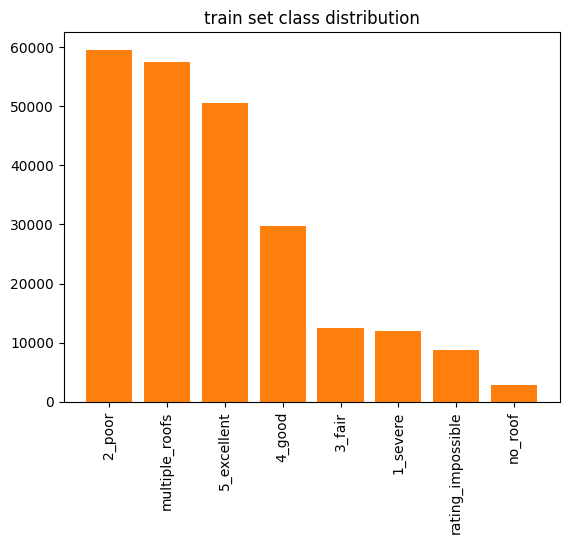

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
entries_train = np.load("/cnvrg/rcr_evaluation_imagenet/entries-TRAIN.npy")
names=['2_poor',
 'multiple_roofs',
 '5_excellent',
 '4_good',
 '3_fair',
 '1_severe',
 'rating_impossible',
 'no_roof']
weights = pd.DataFrame(entries_train).class_name.value_counts().values
plt.bar(names, weights)
y_pos = range(len(names))
plt.bar(y_pos, weights)
# Rotation of the bars names
plt.xticks(y_pos, names, rotation=90)
plt.title("train set class distribution")


Text(0.5, 1.0, 'test set class distribution')

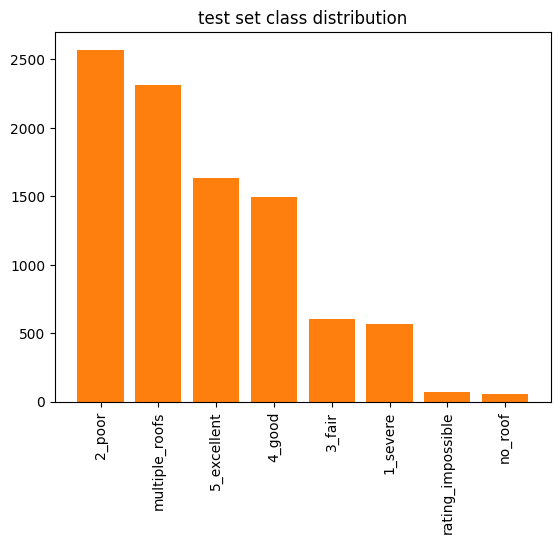

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
entries_train = np.load("/cnvrg/rcr_evaluation_imagenet/entries-VAL.npy")
names=['2_poor',
 'multiple_roofs',
 '5_excellent',
 '4_good',
 '3_fair',
 '1_severe',
 'rating_impossible',
 'no_roof']
weights = pd.DataFrame(entries_train).class_name.value_counts().values
plt.bar(names, weights)
y_pos = range(len(names))
plt.bar(y_pos, weights)
# Rotation of the bars names
plt.xticks(y_pos, names, rotation=90)
plt.title("test set class distribution")
